In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
import sys
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pickle
from time import time
from scipy.sparse import spdiags
%matplotlib inline  
np.set_printoptions(threshold=sys.maxsize)

In [2]:
plot_fig = True
save_data = False
Re = 10000
nx = 60
ny = nx
ic = 2  # initial condition, 1: Sine, 2: Gaussian
nt = 200
tstop = 1.5
dt = tstop/nt
t = np.linspace(0, tstop, nt+1)
nxy = (nx-2)*(ny-2)
dx = 1/(nx-1)
dy = 1/(ny-1)
maxitr = 10
tol = 1e-8

# parameters
amp_arr = np.array([0.7])
width_arr = np.array([0.9])

# amp_arr = np.array([0.6, 1.0])
# width_arr = np.array([0.8, 1.2])

# amp_arr = np.linspace(0.6, 1.0, 18)
# width_arr = np.linspace(0.8, 1.2, 18)

# amp_arr = np.linspace(0.7, 0.9, 21)
# width_arr = np.linspace(0.9, 1.1, 21)

In [3]:
if ic == 1: # sine
    xmin = 0
    xmax = 1
    ymin = 0
    ymax = 1
elif ic == 2: # Gaussian
    xmin = -3
    xmax = 3
    ymin = -3
    ymax = 3
    x0 = 0 # Gaussian center
    y0 = 0 # Gaussian center
else: 
    print('wrong values for IC!')
I=sp.eye(nxy,format='csr')

# full indicies, free indicies, fixed indicies
[xv,yv]=np.meshgrid(np.linspace(xmin,xmax,nx),np.linspace(ymin,ymax,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# boundary one-hot vector
x0_one_hot=np.eye(nx-2)[0]
y0_one_hot=np.eye(ny-2)[0]
x1_one_hot=np.eye(nx-2)[-1]
y1_one_hot=np.eye(ny-2)[-1]

# inner grid
inner_multi_index_i,inner_multi_index_j=np.meshgrid(np.arange(nx-2),np.arange(ny-2),indexing='xy')
inner_x_multi_index=(np.concatenate((inner_multi_index_j[:,0].flatten(),inner_multi_index_j[:,-1].flatten())),
                     np.concatenate((inner_multi_index_i[:,0].flatten(),inner_multi_index_i[:,-1].flatten())))
inner_y_multi_index=(np.concatenate((inner_multi_index_j[0,:].flatten(),inner_multi_index_j[-1,:].flatten())),
                     np.concatenate((inner_multi_index_i[0,:].flatten(),inner_multi_index_i[-1,:].flatten())))

inner_dims=(ny-2,nx-2)
inner_x_raveled_indicies=np.ravel_multi_index(inner_x_multi_index,inner_dims)
inner_y_raveled_indicies=np.ravel_multi_index(inner_y_multi_index,inner_dims)


# first order derivative
# central
Mcb=sp.diags([np.zeros(nx-2),-np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Mc=sp.kron(sp.eye(ny-2),Mcb,format="csr")

Ib=sp.eye(nx-2)
Nc=sp.kron(sp.diags([np.zeros(ny-2),-np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

# forward
Mfb=sp.diags([-np.ones(nx-2),np.ones(nx-2)],[0,1],(nx-2,nx-2))
Mf=sp.kron(sp.eye(ny-2),Mfb,format="csr")

Ib=sp.eye(nx-2)
Nf=sp.kron(sp.diags([-np.ones(ny-2),np.ones(ny-2)],[0,1],(ny-2,ny-2)),Ib,format="csr")

# backward
Mbb=sp.diags([np.ones(nx-2),-np.ones(nx-2)],[0,-1],(nx-2,nx-2))
Mb=sp.kron(sp.eye(ny-2),Mbb,format="csr")

Ib=sp.eye(nx-2)
Nb=sp.kron(sp.diags([np.ones(ny-2),-np.ones(ny-2)],[0,-1],(ny-2,ny-2)),Ib,format="csr")

# laplacian operator
Dxb=sp.diags([-2*np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Dx=sp.kron(sp.eye(ny-2),Dxb,format="csr")

Ib=sp.eye(nx-2)
Dy=sp.kron(sp.diags([-2*np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

In [4]:
### Compact Finite Difference Method ###
def D_Lele(N,h):
    d=[-1, 0, 1];
    B1=3/8*np.ones(N)
    B2=3/8*np.ones(N)
    B1[-2]=3
    B1[-3]=1/4
    B1[-4]=1/3
    B1[0]=1/4
    B1[1]=1/3
    B2[1]=3
    B2[2]=1/4
    B2[3]=1/3
    B2[-1]=1/4
    B2[-2]=1/3
    A=spdiags([B1, np.ones(N), B2],d, N,N)
    
    alf=25/32/h
    bet=1/20/h
    gam=-1/480/h
    d=np.arange(-3,4)
    
    # d=-3
    B1=-gam*np.ones(N)
    B1[-4]=1/6/h
    B1[-5]=0
    B1[-6]=0
    # d=-2
    B2=-bet*np.ones(N)
    B2[0]=-1/36/h
    B2[-3]=-3/2/h
    B2[-4]=0
    B2[-5]=-1/36/h
    # d = -1
    B3=-alf*np.ones(N)
    B3[0]=-3/4/h
    B3[1]=-7/9/h
    B3[-2]=-3/2/h
    B3[-3]=-3/4/h
    B3[-4]=-7/9/h
    # d = 0
    B4=np.zeros(N)
    B4[0]=-17/6/h
    B4[-1]=17/6/h
    # d = 1
    B5=alf*np.ones(N)
    B5[1]=3/2/h
    B5[2]=3/4/h
    B5[3]=7/9/h
    B5[-1]=3/4/h
    B5[-2]=7/9/h
    # d = 2
    B6=bet*np.ones(N)
    B6[2]=3/2/h
    B6[3]=0
    B6[4]=1/36/h
    B6[-1]=1/36/h
    # d = 3
    B7=gam*np.ones(N)
    B7[3]=-1/6/h
    B7[4]=0
    B7[5]=0
    B=spdiags([B1, B2, B3, B4, B5, B6, B7],d,N,N)
    return spsolve(A.tocsc(),B.tocsc()) 

In [5]:
# # verify initial condition
# xmin = -3
# xmax = 3
# ymin = -3
# ymax = 3
# [xv,yv]=np.meshgrid(np.linspace(xmin,xmax,nx),np.linspace(ymin,ymax,ny),indexing='xy')

# amp = amp_arr[0]
# width = width_arr[0]
# zv = amp * np.exp(-0.5*((xv-x0)**2 + (yv-y0)**2) / width**2)

# fig = plt.figure(figsize=(8,3))
# ax_u = fig.add_subplot(121)
# p_u=ax_u.pcolor(xv, yv, zv)
# cb_u=fig.colorbar(p_u, ax=ax_u)
# ax_u.set_xlabel('$x$')
# ax_u.set_ylabel('$y$')
# ax_u.set_title('$u$')  

# ax_u = fig.add_subplot(122, projection='3d')
# ax_u.plot_surface(xv, yv, zv, cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
# ax_u.set_xlabel('$x$')
# ax_u.set_ylabel('$y$')
# ax_u.set_title('$u$')  

In [6]:
def generate_dataset(ic, amp, width, plot_fig=False):
    print(f'Amplitude: {amp}, Width: {width}')
    timer = []
    timer.append(time())

    # compute u_full and v_full
    if ic == 1: # IC: sine
        zv=amp*np.sin(2*np.pi*xv)*np.sin(2*np.pi*yv)
        zv[np.nonzero(xv>0.5)]=0.0
        zv[np.nonzero(yv>0.5)]=0.0
    elif ic == 2: # IC: Gaussian
#         zv = amp * np.exp(-0.5*((xv-x0)**2 + (yv-y0)**2) / width**2)
        zv = amp * np.exp(-((xv-x0)**2 + (yv-y0)**2) / width)
        z = zv.flatten()
    u0 = z.copy()
    v0 = z.copy()

    # plot IC
    if plot_fig:
        fig = plt.figure(figsize=(15,3))
#         ax_u = fig.add_subplot(141, projection='3d')
#         ax_u.plot_surface(xv, yv, u0.reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
#         ax_u.view_init(elev=30,azim=30)
        ax_u = fig.add_subplot(141)
        p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u0.reshape(ny,nx))
        cb_u=fig.colorbar(p_u, ax=ax_u)
        ax_u.set_xlabel('$x$')
        ax_u.set_ylabel('$y$')
        ax_u.set_title('$u$')
        
#         ax_v = fig.add_subplot(143, projection='3d')
#         ax_v.plot_surface(xv, yv, v0.reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
#         ax_v.view_init(elev=30,azim=60)
        ax_v = fig.add_subplot(143)
        p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), v0.reshape(ny,nx))
        cb_v=fig.colorbar(p_v, ax=ax_v)
        ax_v.set_xlabel('$x$')
        ax_v.set_ylabel('$y$')
        ax_v.set_title('$v$')

    # boundary for first order derivative term
    Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
    Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
    Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
    Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
    Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
    Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
    Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
    Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])

    # boundary for second order derivative term
    bxu_cur=np.zeros(nxy)
    byu_cur=np.zeros(nxy)
    bxv_cur=np.zeros(nxy)
    byv_cur=np.zeros(nxy)

    bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
    byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
    bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
    byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]

    def r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
          Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
          bxu_cur,bxv_cur,byu_cur,byv_cur):

        f_u=(-1/dx*(u_free*(Mu_free - Bdudx0_cur))
        -1/dy*(v_free*(Nu_free - Bdudy0_cur))
        +1/(Re*dx**2)*(Dx.dot(u_free) + bxu_cur)
        +1/(Re*dy**2)*(Dy.dot(u_free) + byu_cur))
        
        f_v=(-1/dx*(u_free*(Mv_free - Bdvdx0_cur))
        -1/dy*(v_free*(Nv_free - Bdvdy0_cur))
        +1/(Re*dx**2)*(Dx.dot(v_free) + bxv_cur)
        +1/(Re*dy**2)*(Dy.dot(v_free) + byv_cur))

        r_u=u_free-u_free_prev-dt*f_u
        r_v=v_free-v_free_prev-dt*f_v

        return np.concatenate((r_u,r_v))



    def J(u_free,v_free,Mu_free,Mv_free,Nu_free,Nv_free,
          Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur):

        df_udu = (-1/dx*(sp.diags(Mu_free - Bdudx0_cur,0,(nxy,nxy),format="csr") 
                            + sp.diags(u_free,0,(nxy,nxy),format="csr").dot(Mb))
        -1/dy*sp.diags(v_free,0,(nxy,nxy),format="csr").dot(Nb)
        +1/(Re*dx**2)*Dx
        +1/(Re*dy**2)*Dy)
        df_udv = -1/dy*sp.diags(Nu_free - Bdudy0_cur,0,(nxy,nxy),format="csr")
        df_vdu = -1/dx*sp.diags(Mv_free - Bdvdx0_cur,0,(nxy,nxy),format="csr")
        df_vdv = (-1/dx*sp.diags(u_free,0,(nxy,nxy),format="csr").dot(Mb)
        -1/dy*(sp.diags(Nv_free - Bdvdy0_cur,0,(nxy,nxy),format="csr")
                   + sp.diags(v_free,0,(nxy,nxy),format="csr").dot(Nb))
        +1/(Re*dx**2)*Dx
        +1/(Re*dy**2)*Dy)

        return sp.bmat([[I-dt*df_udu,-dt*df_udv],[-dt*df_vdu,I-dt*df_vdv]],format='csr')

    # solution snapshot
    u_full=np.zeros(((nt+1),ny*nx))
    v_full=np.zeros(((nt+1),ny*nx))
    
    # solution + intermediate snapshot
    u_full_inter=np.array([])
    v_full_inter=np.array([])

    # IC
    u_full[0]=np.copy(u0)
    v_full[0]=np.copy(v0)
    u0_free=u0[free_raveled_indicies]
    v0_free=v0[free_raveled_indicies]

    for k in range(nt):
#         print("")
#         print(k,"th time step:")

        u_free_prev=np.copy(u_full[k,free_raveled_indicies])
        v_free_prev=np.copy(v_full[k,free_raveled_indicies])

        u_free=np.copy(u_full[k,free_raveled_indicies])
        v_free=np.copy(v_full[k,free_raveled_indicies])

        Mu_free=Mb.dot(u_free)
        Mv_free=Mb.dot(v_free)
        Nu_free=Nb.dot(u_free)
        Nv_free=Nb.dot(v_free)

        residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
                   Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
                   bxu_cur,bxv_cur,byu_cur,byv_cur)

        for itr in range(maxitr):
            jacobian=J(u_free,v_free,Mu_free,Mv_free,Nu_free,Nv_free,
                       Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur)

            delta_free=spsolve(jacobian, -residual)

            u_free+=delta_free[:nxy]
            v_free+=delta_free[nxy:]

            Mu_free=Mb.dot(u_free)
            Mv_free=Mb.dot(v_free)
            Nu_free=Nb.dot(u_free)
            Nv_free=Nb.dot(v_free)

            residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
                       Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
                       bxu_cur,bxv_cur,byu_cur,byv_cur)
       
            # store itermediate values
#             u_full_inter = np.append(u_full_inter,u_free)
#             v_full_inter = np.append(v_full_inter,v_free)
        
            R=np.linalg.norm(residual)
#             print(itr,"th Newton iteration", "R:", R)

            if R<tol:
                u_full[k+1,free_raveled_indicies]=np.copy(u_free)
                v_full[k+1,free_raveled_indicies]=np.copy(v_free)
                # BC from exact solution
                u_full[k+1,fixed_raveled_indicies]=np.copy(u0[fixed_raveled_indicies])
                v_full[k+1,fixed_raveled_indicies]=np.copy(v0[fixed_raveled_indicies])
                break

        if R>=tol:
            print("\n non converged after {}th iteration".format(maxitr))
            break     
    timer.append(time())
    time_fom = timer[1]-timer[0]
    
    #     u_full[k+1,free_raveled_indicies]=np.copy(u_free)
    #     v_full[k+1,free_raveled_indicies]=np.copy(v_free)
    #     # BC from exact solution
    #     u_full[k+1,fixed_raveled_indicies]=np.copy(u[k+1,fixed_raveled_indicies])
    #     v_full[k+1,fixed_raveled_indicies]=np.copy(v[k+1,fixed_raveled_indicies])
    
#     u_full_inter=u_full_inter.reshape(-1,nxy)
#     v_full_inter=v_full_inter.reshape(-1,nxy)
    
    # plot solution at final time step
    if plot_fig:
        ax_u = fig.add_subplot(142)
        # ax_u = Axes3D(fig_u)
        # ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), u_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
        # ax_u.view_init(elev=30,azim=30)
        ax_u = plt.gca()
        p_u=ax_u.pcolor(xv, yv, (u_full[-1]).reshape(ny,nx))
        cb_u=fig.colorbar(p_u, ax=ax_u)
        ax_u.set_xlabel('$x$')
        ax_u.set_ylabel('$y$')
        ax_u.set_title('$u$')

        ax_v = fig.add_subplot(144)
        # ax_v = Axes3D(fig_v)
        # ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), v_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
        # ax_v.view_init(elev=30,azim=60)
        ax_v = plt.gca()
        p_v=ax_v.pcolor(xv, yv, (v_full[-1]).reshape(ny,nx))
        cb_v=fig.colorbar(p_v, ax=ax_v)
        ax_v.set_xlabel('$x$')
        ax_v.set_ylabel('$y$')
        ax_v.set_title('$v$')
        plt.tight_layout()
        plt.show()  

    return u_full.reshape(-1,ny*nx), v_full.reshape(-1,ny*nx),time_fom

def derivative(X):
    dXdt = np.empty(X.shape)
    D = D_Lele(X.shape[0], tstop/X.shape[0])   
    for i in range(X.shape[1]):
        dXdt[:,i] = np.dot(D.toarray(), X[:,i])
    del D
    return dXdt

### Generate and save data in one file

Amplitude: 0.7, Width: 0.9


/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:189: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eith

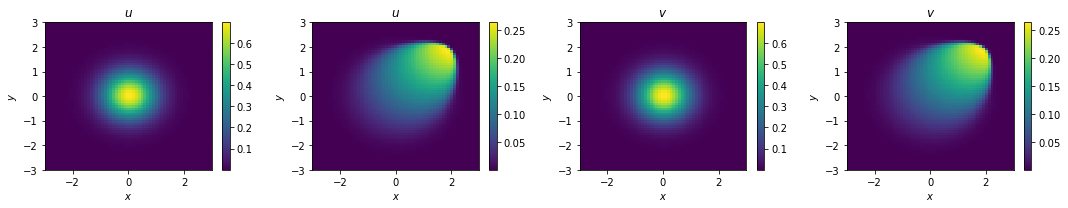

amplitude: 0.7, width: 0.9, shape: (201, 3600), (201, 3600)
time for computing x: 37.62 s


In [7]:
# generate training set
data = []
param = []
time_fom = 0
for i in amp_arr:
    for j in width_arr:
        snapshot = {}
        param.append(np.array([i, j]))

        # compute u, v
        u, v, t_fom = generate_dataset(ic, i, j, plot_fig=plot_fig)
        print(f'amplitude: {i}, width: {j}, shape: {u.shape}, {v.shape}')
        snapshot['u'] = u
        snapshot['v'] = v
        snapshot['t'] = t
        snapshot['time_fom'] = t_fom
        time_fom += t_fom
        
        # compute du/dt, dv/dt
        dudt = derivative(u)
        dvdt = derivative(v)
        snapshot['du'] = dudt
        snapshot['dv'] = dvdt

        data.append(snapshot)

data_all = {}
data_all['data'] = data
data_all['param'] = param
print(f"time for computing x: {time_fom/len(data_all['data']):.2f} s")

In [8]:
print(data[0]['u'].min(), data[0]['u'].max(), data[0]['du'].min(), data[0]['du'].max())
print(data[0]['v'].min(), data[0]['v'].max(), data[0]['dv'].min(), data[0]['dv'].max())

1.4428075357069904e-09 0.6959896987687743 -2.858981444060498 5.754856213613457
1.4428075357069904e-09 0.6959896987687743 -2.858981444060498 5.754856213613457


/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


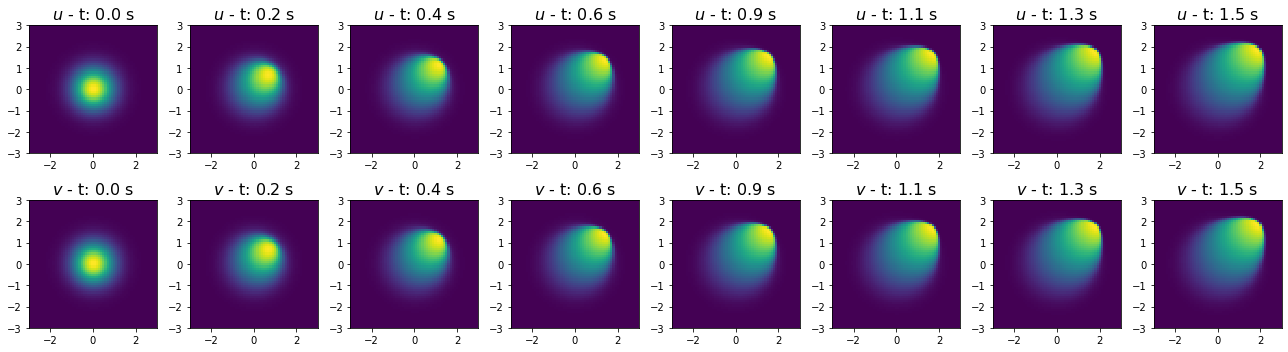

In [9]:
nplot = 8
step_list = np.linspace(0,nt,nplot,dtype=int)
vmin = data[0]['u'].min()
vmax = data[0]['u'].max()

fig = plt.figure(figsize=(18,5))
for i,step in enumerate(step_list):
    ax_u = fig.add_subplot(2,nplot,i+1)
    ax_u = plt.gca()
    p_u=ax_u.pcolor(xv, yv, (data[0]['u'][step]).reshape(ny,nx))
#     p_u=ax_u.pcolor(xv, yv, (data[0]['u'][step]).reshape(ny,nx), vmin=vmin, vmax=vmax)
#     cb_u=fig.colorbar(p_u, ax=ax_u)
#     ax_u.set_xlabel('$x$')
#     ax_u.set_ylabel('$y$')
    ax_u.set_title(f'$u$ - t: {step/nt*tstop:.1f} s',fontsize=16)
    
for i,step in enumerate(step_list):
    ax_u = fig.add_subplot(2,nplot,i+1+nplot)
    ax_u = plt.gca()
    p_u=ax_u.pcolor(xv, yv, (data[0]['v'][step]).reshape(ny,nx))
#     p_u=ax_u.pcolor(xv, yv, (data[0]['u'][step]).reshape(ny,nx), vmin=vmin, vmax=vmax)
#     cb_u=fig.colorbar(p_u, ax=ax_u)
#     ax_u.set_xlabel('$x$')
#     ax_u.set_ylabel('$y$')
    ax_u.set_title(f'$v$ - t: {step/nt*tstop:.1f} s',fontsize=16)
plt.tight_layout()
plt.savefig('./2dBurger_u_multisteps.png')

/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


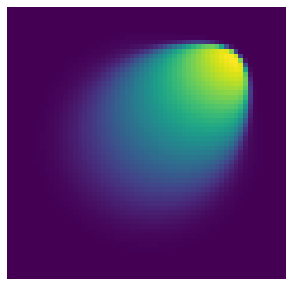

In [10]:
t = np.linspace(0,tstop,nt+1)
step_list = np.linspace(0,nt,10,dtype=int)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for step in step_list:
    ax = plt.gca()
    ax.pcolor(xv, yv, (data[0]['u'][step]).reshape(ny,nx))
    plt.axis('off')
    plt.savefig(f'./data/snapshot/t{t[step]:.1f}s.png')

In [11]:
num_case = len(data)

# save data
if save_data:
    if num_case > 1:
        pickle.dump(data_all, open(f"./data/local{num_case}_Re{Re}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "wb"))
    else:
        pickle.dump(data_all, open(f"./data/local{num_case}_Re{Re}_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "wb"))

### Generate and save data in separate files

In [12]:
# amp_arr = np.arange(0.5,1.1,0.05)
# for i in amp_arr:
#     data = []
#     param = []
#     snapshot = {}
#     param.append(np.array([i]))

#     # compute u, v
#     u, v = generate_dataset(i, plot_fig=plot_fig)
#     print(f'amplitude: {i}, shape: {u.shape}, {v.shape}')
#     snapshot['u'] = u
#     snapshot['v'] = v
#     snapshot['t'] = t

#     # compute du/dt, dv/dt
#     dudt = derivative(u)
#     dvdt = derivative(v)
#     snapshot['du'] = dudt
#     snapshot['dv'] = dvdt

#     data.append(snapshot)

#     data_all = {}
#     data_all['data'] = data
#     data_all['param'] = param

#     pickle.dump(data_all, open(f"./data/local1_Re{Re}_A{i:.2f}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "wb"))